## Importing Libraries

This cell imports various Python libraries and packages that will be used throughout the credit card fraud detection project. Here is a brief description of each imported package:

- `pandas` and `numpy`: These libraries are essential for data manipulation and numerical operations.
- `matplotlib.pyplot` and `seaborn`: These are used for data visualization and plotting.
- `plotly.express`, `plotly.graph_objects`, and `plotly.subplots`: These are used for interactive and advanced data visualization.
- `sklearn` modules: Scikit-learn is a machine learning library, and these modules are used for data preprocessing, modeling, and evaluation.
- `stats` from `scipy`: This is used for various statistical calculations.
- `imblearn.over_sampling.SMOTE`: This is used for addressing class imbalance in the dataset.
- `xgboost`: XGBoost is a popular gradient boosting library used for classification tasks.

These libraries will be essential for data analysis, feature engineering, model building, and evaluation throughout the project.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.preprocessing import StandardScaler, PowerTransformer
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from sklearn.datasets import make_classification
from sklearn.svm import OneClassSVM
from sklearn.metrics import (roc_curve, roc_auc_score, classification_report, confusion_matrix,
    accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score, auc,
    f1_score, precision_recall_curve, average_precision_score)

import xgboost as xgb
from imblearn.over_sampling import SMOTE

## Loading and Exploring the Dataset

This cell is responsible for loading the credit card dataset from the 'creditcard.csv' file and creating a copy of it for further analysis. The `head()` method is used to display the initial records of the dataset. This step is essential for getting an overview of the dataset's contents and structure.


In [3]:
credit_card = pd.read_csv('creditcard.csv')
df = credit_card.copy()
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data Pre-Processing

* Data Cleaning: (Missing Values)

In [4]:
missing_values = df.isnull().sum()

*  Handeling the Outliers:

In [5]:
z_scores = stats.zscore(df)
abs_z_scores = np.abs(z_scores)
outliers = (abs_z_scores > 3).all(axis=1)
df = df[~outliers]

* Data Scaling: (StandardScaling)

In [6]:
scaler = StandardScaler()
df.iloc[:, 1:29] = scaler.fit_transform(df.iloc[:, 1:29])

* Handling the Duplicates

In [7]:
# Check for duplicate rows in the entire DataFrame
duplicate_rows = df[df.duplicated(keep='first')]

# Remove duplicate rows (keep the first occurrence)
df = df.drop_duplicates(keep='first')

* VIF:

In [8]:
# creating dummies for gender
# the independent variables set
X = df.iloc[:, :-1]

# VIF dataframe
vif_df = pd.DataFrame()
vif_df["feature"] = X.columns

# calculating VIF for each feature
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

In [12]:
vif_df_sorted = vif_df.set_index('feature').sort_values(by='VIF', ascending=False)

# Create the bar plot
# fig = px.bar(vif_df_sorted, x=vif_df_sorted.index, y='VIF')
# fig.update_xaxes(title_text='Feature')
# fig.update_yaxes(title_text='VIF value')
# fig.update_layout(template='plotly_dark')
# fig.show()

![Plot](plots/1.png)

* ### Data Transformation using Yeo-Johnson Method

In this cell, I apply the Yeo-Johnson transformation to the dataset as a preprocessing step. The Yeo-Johnson method is a power transformation technique used to make data more closely follow a normal distribution. This transformation can be beneficial for certain machine learning algorithms and helps in dealing with skewed data.

In [13]:
# yeo-johnson method wil be nice
column_trans = ColumnTransformer(
    [('yeo-johnson', PowerTransformer(method='yeo-johnson'), list(df.iloc[:,:-1].columns))],
    remainder='passthrough')
transformed = column_trans.fit_transform(df)
df_transformed = pd.DataFrame(transformed, columns=df.columns)
df_transformed.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-2.435030,-0.924089,-0.125072,2.176813,0.988860,-0.257810,0.452860,0.195910,0.024863,0.382141,...,-0.007799,0.368923,-0.190462,0.008835,0.209741,-0.320841,0.323595,-0.053400,1.117873,0.0
1,-2.435030,0.627764,0.101014,-0.028973,0.390020,0.031065,0.037523,-0.063361,0.011142,-0.184322,...,-0.302257,-0.884630,0.152519,-0.639427,0.286596,0.357278,-0.042726,0.057647,-1.129040,0.0
2,-2.434772,-0.923495,-0.881364,1.379518,0.343635,-0.376589,1.329479,0.644182,0.178109,-1.455034,...,0.361432,1.070661,1.505837,-1.129617,-0.653575,-0.205727,-0.160245,-0.174385,1.622430,0.0
3,-2.434772,-0.755640,-0.197369,1.399248,-0.579112,-0.020154,0.985452,0.194292,0.315706,-1.320698,...,-0.134821,-0.011057,-0.318238,-1.749553,1.280259,-0.397725,0.140647,0.201537,1.011323,0.0
4,-2.434542,-0.839805,0.537358,1.159339,0.359454,-0.307477,0.178878,0.483066,-0.331845,0.772794,...,0.004665,1.108847,-0.233729,0.140332,-0.430614,1.048870,0.547440,0.667171,0.691723,0.0


In [14]:
X = df_transformed.iloc[:, :-1]

# VIF dataframe
vif_data_transformed = pd.DataFrame()
vif_data_transformed["feature"] = X.columns

# calculating VIF for each feature
vif_data_transformed["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

In [15]:
vif_data_transformed = vif_data_transformed.set_index('feature').sort_values(by='VIF', ascending=False)

# Create the bar plot
# fig = px.bar(vif_data_transformed, x=vif_data_transformed.index, y='VIF')
# fig.update_xaxes(title_text='Feature')
# fig.update_yaxes(title_text='VIF value')
# fig.update_layout(template='plotly_dark')
# fig.show()

![Plot](plots/2.png)

## Exploratory Data Analysis (EDA)

* ### Exploring Feature Distributions with Histograms and KDE

In this cell, I visualize the distributions of the dataset's features using histograms overlaid with Kernel Density Estimation (KDE) plots. Each subplot represents a feature, allowing us to understand the data's underlying distribution patterns. This visualization is essential for data exploration and identifying potential outliers or patterns in the data.

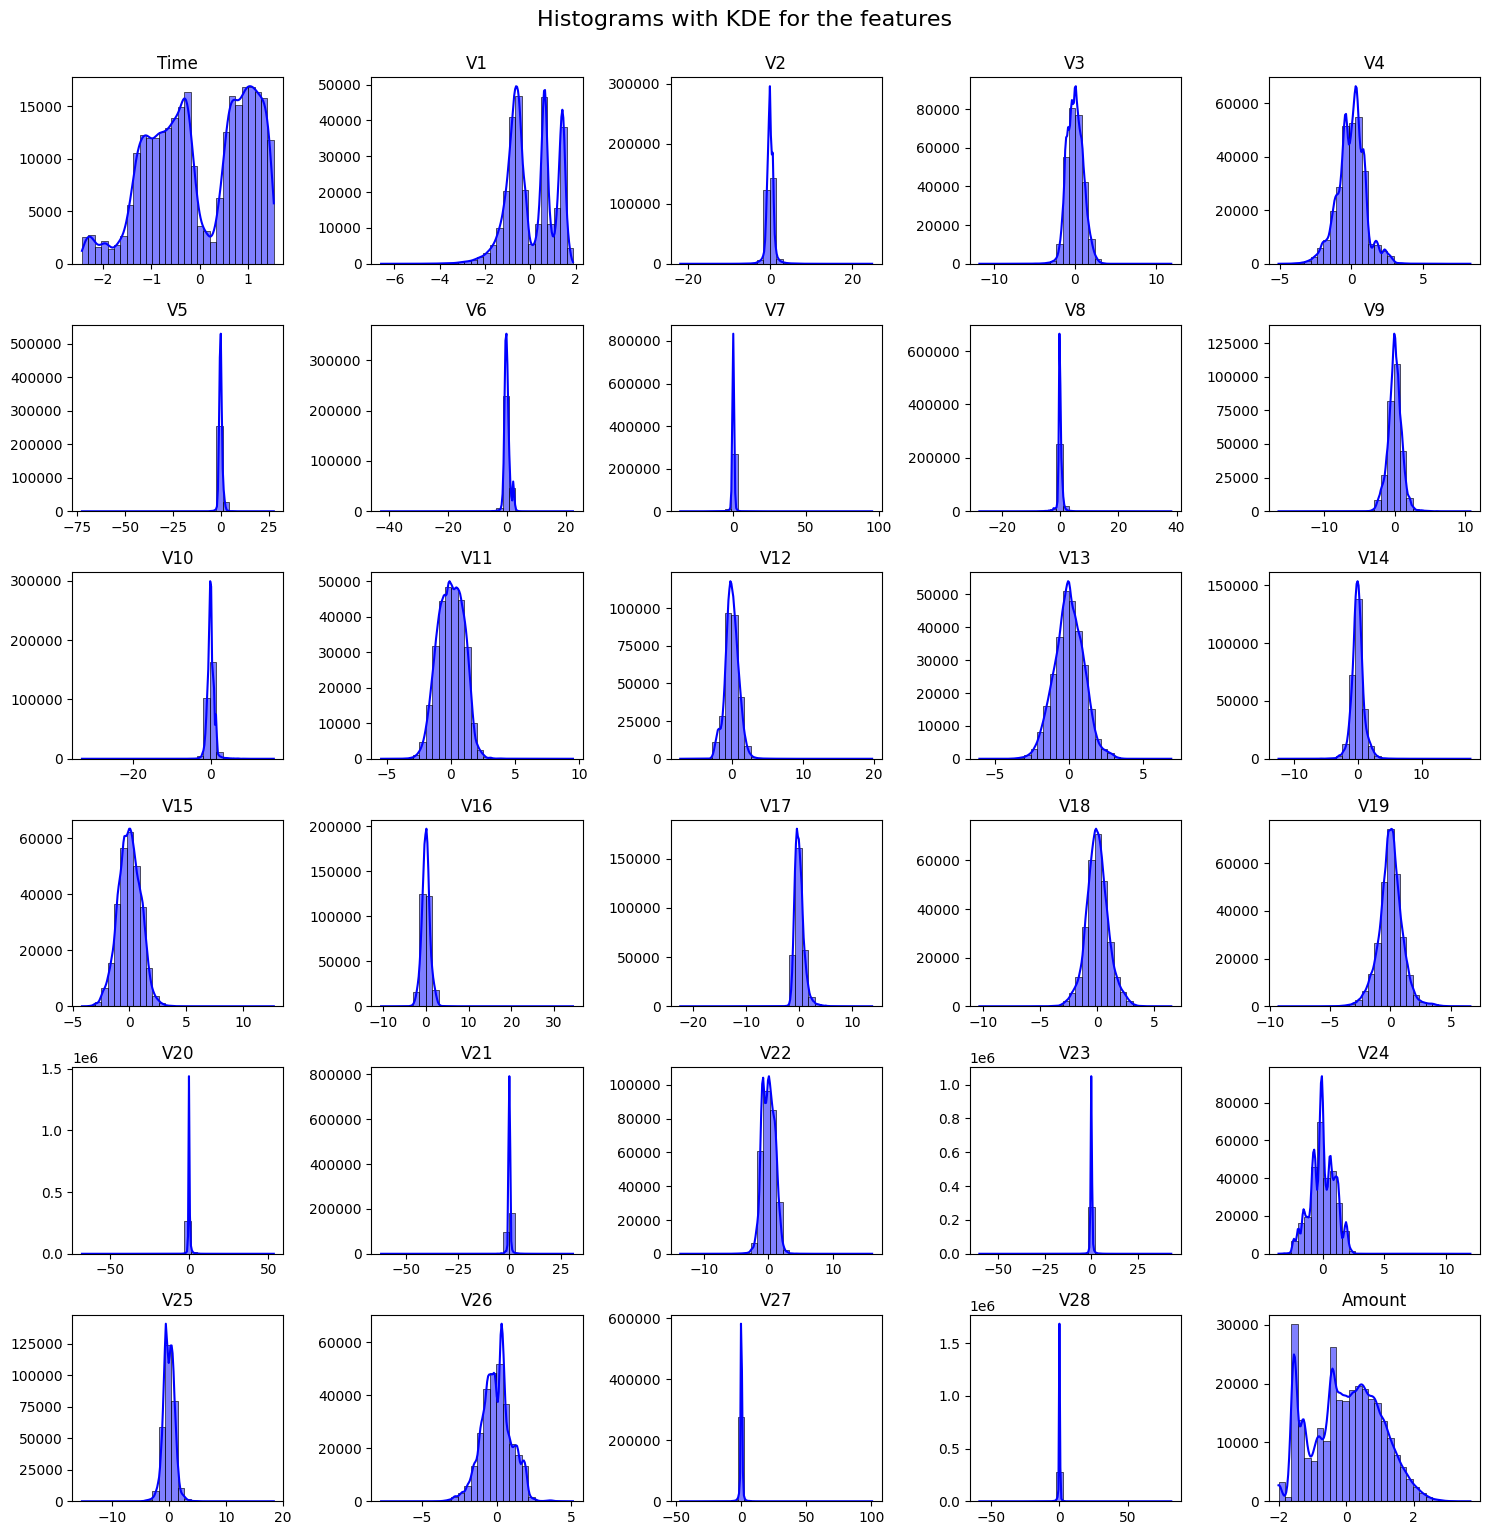

In [16]:
# features = df_transformed.iloc[:, :-1]
features = df_transformed.drop('Class', axis=1)

# Create a figure with subplots
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(15, 15))

# Flatten the axes to iterate over them
axes = axes.flatten()

# Create histograms and overlay KDE plots for each column
for i, col in enumerate(features.columns):
    sns.histplot(features[col], bins=30, ax=axes[i], kde=True, color='blue', edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
plt.tight_layout()
plt.suptitle('Histograms with KDE for the features', y=1.02, fontsize=16)
plt.show()

* ### Mapping Class Labels and Visualizing Class Distribution

Here, I map class labels to more descriptive names ('No Fraud' and 'Fraud') for better understanding. I also create a bar plot that illustrates the distribution of these class labels. This visualization helps us assess the balance between 'No Fraud' and 'Fraud' instances in the dataset, which is important for building a machine learning model.

In [17]:
# Map class labels
df_transformed_n = df_transformed.copy()
class_mapping = {0: 'No Fraud', 1: 'Fraud'}
df_transformed_n['Class'] = df_transformed_n['Class'].map(class_mapping)

# Get class counts
class_counts = df_transformed_n['Class'].value_counts().reset_index()
class_counts.columns = ['Class', 'Count']
print(df_transformed_n['Class'].value_counts())

# Create a bar plot
# fig = px.bar(class_counts, x='Class', y='Count', color='Class',
#              labels={'Count': 'Count'},
#              title='Class Distribution',
#              color_discrete_map={'No Fraud': '#636EFA', 'Fraud': 'salmon'})
# fig.update_layout(template='plotly_dark')
# fig.show()

Class
No Fraud    283253
Fraud          473
Name: count, dtype: int64


![Plot](plots/3.png)

* ### Summary Statistics for Numeric Features

In [18]:
# Summary statistics for numeric features
numeric_summary = df_transformed.drop('Class', axis=1).describe()

* ### Calculating and Visualizing the Correlation Matrix

I calculate the correlation matrix for the dataset's features. The correlation matrix provides insights into the relationships between different features, helping to understand how they are related to each other. I then create a heatmap visualization of the correlation matrix to make it easier to identify patterns and correlations among the features. This visualization is essential for feature selection and understanding feature interdependencies.

In [19]:
# Calculate the correlation matrix
corr_matrix = features.corr()
corr_matrix

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Time,1.000000,0.183769,-0.011007,-0.444214,-0.109684,0.170054,-0.071779,0.083673,-0.045175,-0.011160,...,-0.050290,0.045753,0.145961,0.052214,-0.013763,-0.223507,-0.038256,-0.005035,-0.009725,-0.026734
V1,0.183769,1.000000,-0.259714,-0.314953,0.092250,-0.075327,-0.004353,-0.112120,-0.114056,0.099129,...,-0.093041,-0.016439,-0.018924,0.006263,0.000491,0.039620,0.002141,-0.040878,0.016336,-0.084359
V2,-0.011007,-0.259714,1.000000,-0.049676,0.043734,-0.013523,0.010020,-0.026977,0.137548,0.010375,...,0.039311,-0.020013,-0.018084,-0.025602,-0.002912,-0.002259,0.013753,0.028342,0.039516,-0.442853
V3,-0.444214,-0.314953,-0.049676,1.000000,0.040278,-0.076529,0.059332,-0.038856,-0.046644,-0.002384,...,-0.001812,0.009336,0.016037,-0.034699,-0.003523,0.007308,-0.000084,-0.011272,0.006124,-0.018270
V4,-0.109684,0.092250,0.043734,0.040278,1.000000,0.004345,-0.016279,0.015352,0.002115,0.039143,...,0.002331,-0.003855,-0.008369,0.014507,-0.014448,-0.000976,0.017292,-0.003590,-0.009238,-0.015066
V5,0.170054,-0.075327,-0.013523,-0.076529,0.004345,1.000000,-0.068092,-0.005149,-0.069484,0.011149,...,-0.005622,0.009962,-0.001192,0.002954,0.029676,0.008139,0.007127,-0.007515,-0.004576,-0.276459
V6,-0.071779,-0.004353,0.010020,0.059332,-0.016279,-0.068092,1.000000,0.020190,0.060484,-0.002967,...,0.001521,-0.011823,0.008802,-0.015125,-0.002612,-0.007829,-0.006548,-0.035781,0.020458,0.158875
V7,0.083673,-0.112120,-0.026977,-0.038856,0.015352,-0.005149,0.020190,1.000000,-0.168645,0.007014,...,0.002398,0.038881,-0.005496,0.006857,-0.005012,0.002275,-0.001215,0.006016,-0.010265,0.083199
V8,-0.045175,-0.114056,0.137548,-0.046644,0.002115,-0.069484,0.060484,-0.168645,1.000000,-0.013055,...,0.016648,0.068727,-0.015569,0.011406,0.013342,0.002443,-0.001321,-0.003635,0.000513,-0.023007
V9,-0.011160,0.099129,0.010375,-0.002384,0.039143,0.011149,-0.002967,0.007014,-0.013055,1.000000,...,-0.008881,0.012763,-0.004754,0.002096,-0.000713,-0.007358,-0.012828,0.018675,-0.010812,-0.089306


In [20]:
# Create a heatmap
# fig = px.imshow(corr_matrix,
#                 color_continuous_scale='ice',  # You can choose from other built-in scales
#                 labels={'color': 'Correlation'},
#                 x=corr_matrix.index,
#                 y=corr_matrix.columns,
#                 title='Correlation Heatmap')
# fig.update_layout(width=1100, height=800, template='plotly_dark')
# fig.show()

![Plot](plots/4.png)

* ### Transaction Amount Distribution by Class (Box Plot)

I create a box plot to visually compare the distribution of transaction amounts between different transaction classes, specifically 'No Fraud' and 'Fraud'. The box plot provides insights into the central tendency, spread, and potential outliers within each class, helping to identify differences in transaction amounts based on class labels. This visualization aids in understanding the characteristics of transactions in terms of their amounts for fraud detection.

In [21]:
# Transaction Amount Distribution by Class (Box Plot)
# box_plot_amount_by_class_fig = px.box(df_transformed_n, x='Class', y='Amount', color='Class',
#                                       labels={'Class': 'Transaction Class', 'Amount': 'Transaction Amount'},
#                                       title='Transaction Amount Distribution by Class')
# box_plot_amount_by_class_fig.update_layout(template='plotly_dark')
# box_plot_amount_by_class_fig.show()

![Plot](plots/5.png)

* ### Time-Based Analysis of Transaction Amounts

I conduct time-based analysis to explore how transaction amounts vary over time, considering different transaction classes ('No Fraud' and 'Fraud'). There are two line plots created:

1. **Transaction Amount Over Time (Full Range)**:
   - The first line plot, titled 'Transaction Amount Over Time,' displays the transaction amount on the y-axis and time on the x-axis.
   - Transactions are color-coded by class ('No Fraud' and 'Fraud').
   - This plot shows the entire range of transaction amounts and time values.

2. **Transaction Amount Over Time (Limited Range)**:
   - The second line plot is similar to the first but with a limited y-axis range (0 to 5000).
   - Setting a specific y-axis range can help focus on a particular range of transaction amounts, making it easier to observe patterns within that range.

Both line plots use a dark template for better visibility and aim to provide insights into how transaction amounts change over time and whether there are any time-dependent patterns or differences between transaction classes.

In [22]:
# Time-based analysis
# time_analysis_fig = px.line(df, x='Time', y='Amount', color='Class',
#                             labels={'Time': 'Time', 'Amount': 'Transaction Amount'},
#                             title='Transaction Amount Over Time')
# time_analysis_fig.update_layout(template='plotly_dark')
# time_analysis_fig.show()

![Plot](plots/6.png)

In [23]:
# Create a line plot with a specified y-axis range (0-5000)
# time_analysis_fig_r = px.line(df, x='Time', y='Amount', color='Class',
#                             labels={'Time': 'Time', 'Amount': 'Transaction Amount'},
#                             title='Transaction Amount Over Time',
#                             range_y=[0, 5000])  # Set the y-axis range to 0 - 5000
# time_analysis_fig_r.update_layout(template='plotly_dark')
# time_analysis_fig_r.show()

![Plot](plots/7.png)

* ### Feature Importance Analysis with Random Forest

In the following cell, I perform feature importance analysis using a Random Forest classifier. The steps include:
1. Separating the dataset into features (X) and the target variable (y).
2. Training a Random Forest classifier on the features and target variable.
3. Calculating feature importances, which indicate the significance of each feature for the model's predictions.
4. Creating a visual representation of feature importance using a horizontal bar chart.

This analysis helps identify which features have the most influence on the model's predictions, aiding in feature selection and model interpretation.

In [24]:
# Separate features (X) and target variable (y)
X = df.drop('Class', axis=1)
y = df['Class']

# Initialize and fit a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X, y)

# Get feature importances from the trained model
feature_importances_r = rf_classifier.feature_importances_

# Create a DataFrame to store feature names and their importance scores
feature_importance_df_r = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances_r})

# Sort the features by importance score in descending order
feature_importance_df_r = feature_importance_df_r.sort_values(by='Importance', ascending=False)

In [25]:
# Create a bar chart to visualize feature importance
# fig = px.bar(feature_importance_df_r, x='Importance', y='Feature', orientation='h',
#              title='Feature Importance (Random Forrest)', color='Importance', labels={'Importance': 'Feature Importance'})
# fig.update_traces(marker=dict(color='#636EFA'))
# fig.update_layout(template='plotly_dark')
# fig.show()

![Plot](plots/8.png)

* ### Feature Importance Analysis with XGBoost

In this cell, I perform feature importance analysis using an XGBoost classifier. The steps include:
1. Initializing the XGBoost classifier with a specified random seed.
2. Training the classifier on the features and target variable.
3. Calculating feature importances, indicating the significance of each feature for the model's predictions.
4. Creating a horizontal bar chart to visualize feature importance.

In [26]:
# Initialize and fit an XGBoost classifier
xgb_classifier = xgb.XGBClassifier(random_state=42)
xgb_classifier.fit(X, y)

# Get feature importances from the trained model
feature_importances_x = xgb_classifier.feature_importances_

# Create a DataFrame to store feature names and their importance scores
feature_importance_df_x = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances_x})

# Sort the features by importance score in descending order
feature_importance_df_x = feature_importance_df_x.sort_values(by='Importance', ascending=False)

In [27]:
# Create a bar chart to visualize feature importance
# fig = px.bar(feature_importance_df_x, x='Importance', y='Feature', orientation='h',
#              title='Feature Importance (XGBoost)', color='Importance', labels={'Importance': 'Feature Importance'})
# fig.update_traces(marker=dict(color='#8C564B'))
# fig.update_layout(template='plotly_dark')
# fig.show()

![Plot](plots/9.png)

* ### Feature Importance Analysis with Gradient Boosting

In this cell, we perform feature importance analysis using a Gradient Boosting classifier. The key steps involve:
1. Initializing the Gradient Boosting classifier with a specified random seed.
2. Training the classifier on the features and target variable.
3. Calculating feature importances, indicating the significance of each feature for the model's predictions.
4. Creating a horizontal bar chart to visualize feature importance.

In [28]:
# Initialize and fit a Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X, y)

# Get feature importances from the trained model
feature_importances_g = gb_classifier.feature_importances_

# Create a DataFrame to store feature names and their importance scores
feature_importance_df_g = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances_g})

# Sort the features by importance score in descending order
feature_importance_df_g = feature_importance_df_g.sort_values(by='Importance', ascending=False)

In [29]:
# Create a bar chart to visualize feature importance
# fig = px.bar(feature_importance_df_g, x='Importance', y='Feature', orientation='h',
#              title='Feature Importance (Gradient Boosting)', color='Importance', labels={'Importance': 'Feature Importance'})
# fig.update_traces(marker=dict(color='#B6E880'))
# fig.update_layout(template='plotly_dark')
# fig.show()

![Plot](plots/10.png)

## Modeling:

* ### Logistic Regression Modeling, Evaluation, and Visualization

In this cell, I perform various tasks related to logistic regression modeling and evaluation:

1. **Data Splitting**: I split the dataset into training and testing sets to train and evaluate the logistic regression model.

2. **Hyperparameter Tuning**: Logistic regression models are trained with different class weights for class 1 (fraud) to address class imbalance. Various class weights are tested to find the optimal setting.

3. **Performance Metrics**: Performance metrics such as precision, recall, and F1-score are calculated and displayed for each logistic regression model with different class weights. These metrics assess the model's ability to classify fraud and non-fraud transactions accurately.

4. **Learning Curves**: Learning curves are plotted to visualize how the model's performance changes with varying training set sizes. This helps determine whether the model would benefit from additional data or if it exhibits high variance or bias.

5. **Confusion Matrix**: A confusion matrix is generated and displayed to provide detailed insights into true positives, true negatives, false positives, and false negatives. This helps in assessing the model's performance in classifying fraud and non-fraud transactions.

This thorough analysis assists in understanding the logistic regression model's performance, its sensitivity to class weights, and its potential for improvement with additional data.

In [30]:
X = df_transformed.drop('Class', axis=1)
y = df_transformed['Class']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=110, stratify=y)

In [31]:
weights = [50,60,70,80,100,120]
for weight in weights:
    lg =  LogisticRegression(max_iter=500,C=0.1, class_weight={0: 1, 1: weight})
    lg.fit(X_train, y_train)
    lg_pred = lg.predict(X_test)
    print(f'for class weight of 0:1 and 1:{weight}')
    print(f'precision {precision_score(y_test, lg_pred):.3f}')
    print(f'recall {recall_score(y_test, lg_pred):.3f}')
    print(f'f1 {f1_score(y_test, lg_pred):.3f}')

for class weight of 0:1 and 1:50
precision 0.464
recall 0.859
f1 0.602
for class weight of 0:1 and 1:60
precision 0.386
recall 0.859
f1 0.533
for class weight of 0:1 and 1:70
precision 0.340
recall 0.866
f1 0.488
for class weight of 0:1 and 1:80
precision 0.303
recall 0.866
f1 0.449
for class weight of 0:1 and 1:100
precision 0.248
recall 0.866
f1 0.386
for class weight of 0:1 and 1:120
precision 0.208
recall 0.873
f1 0.336


In [32]:
lg =  LogisticRegression(max_iter=500,C=0.1, class_weight={0: 1, 1: 50},random_state=110)
lg.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight={0: 1, 1: 50}, max_iter=500,
                   random_state=110)

In [33]:
lg_pred = lg.predict(X_test)
print(f'precision score :{precision_score(y_test, lg_pred):.3f}')
print(f'recall score :{recall_score(y_test, lg_pred):.3f}')
print(f'f1 score :{f1_score(y_test, lg_pred):.3f}')

precision score :0.464
recall score :0.859
f1 score :0.602


In [34]:
lg_pred_train = lg.predict(X_train)
print(f'precision score :{precision_score(y_train, lg_pred_train):.3f}')
print(f'recall score :{recall_score(y_train, lg_pred_train):.3f}')
print(f'f1 score :{f1_score(y_train, lg_pred_train):.3f}')

precision score :0.453
recall score :0.852
f1 score :0.591


In [35]:
# Define training set sizes for the learning curve
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculate learning curves
train_sizes, train_scores, valid_scores = learning_curve(lg, X, y, train_sizes=train_sizes, cv=5)

# Calculate the mean and standard deviation of training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

In [36]:
# # Plot learning curves
# fig = go.Figure()

# # Add training curve
# fig.add_trace(go.Scatter(x=train_sizes, y=train_scores_mean,
#                          mode='lines+markers',
#                          name='Training Score',
#                          line=dict(color='red')))

# # Add validation curve
# fig.add_trace(go.Scatter(x=train_sizes, y=valid_scores_mean,
#                          fill='tonexty',
#                          mode='lines+markers',
#                          name='Validation Score',
#                          line=dict(color='green')))

# # Add standard deviation shading
# fig.add_trace(go.Scatter(x=np.concatenate([train_sizes, train_sizes[::-1]]),
#                          y=np.concatenate([train_scores_mean - train_scores_std,
#                                             (train_scores_mean + train_scores_std)[::-1]]),
#                          fill='toself',
#                          fillcolor='rgba(255, 0, 0, 0.2)',
#                          line=dict(color='rgba(255, 255, 255, 0)'),
#                          name='Training Score ± Std Dev'))

# fig.add_trace(go.Scatter(x=np.concatenate([train_sizes, train_sizes[::-1]]),
#                          y=np.concatenate([valid_scores_mean - valid_scores_std,
#                                             (valid_scores_mean + valid_scores_std)[::-1]]),
#                          fill='toself',
#                          fillcolor='rgba(0, 255, 0, 0.2)',
#                          line=dict(color='rgba(255, 255, 255, 0)'),
#                          name='Validation Score ± Std Dev'))

# fig.update_layout(
#     title='Learning Curves',
#     xaxis_title='Training Set Size',
#     yaxis_title='Score',
#     xaxis=dict(gridcolor='lightgray'),
#     yaxis=dict(gridcolor='lightgray'),
#     legend=dict(
#         x=1,      # Change the x-coordinate to 1 (right)
#         y=0,      # Change the y-coordinate to 0 (bottom)
#         bgcolor='rgba(255, 255, 255, 0.7)',  # Optional background color for the legend
#         bordercolor='gray',  # Optional border color for the legend
#     ),
#     showlegend=True, template='plotly_dark')
# fig.show()

![Plot](plots/11.png)

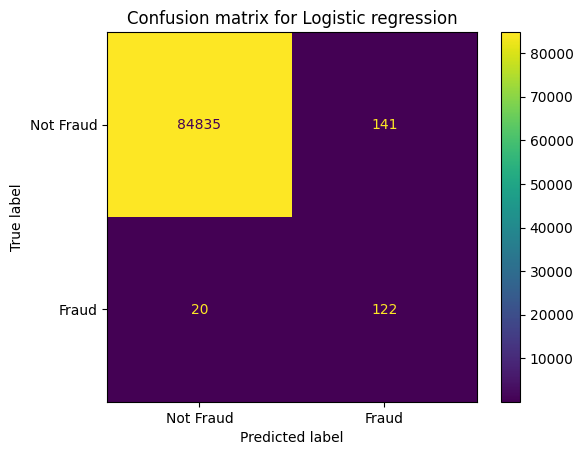

In [37]:
matrix = confusion_matrix(y_test, lg_pred)
matrix_display = ConfusionMatrixDisplay(matrix,display_labels=['Not Fraud','Fraud'])
matrix_display.plot()
plt.title('Confusion matrix for Logistic regression')
plt.show()

* ### Random Forest Classifier Evaluation and ROC Curve

Here, I evaluate the Random Forest classifier's performance and create a Receiver Operating Characteristic (ROC) curve:

1. **Model Training**: I train a Random Forest classifier using the training dataset.

2. **Prediction and Evaluation**: The trained model is used to make predictions on the test dataset, and its performance is assessed using metrics such as precision, recall, F1-score, and the area under the ROC curve (AUC-ROC). These metrics provide insights into the model's ability to classify 'No Fraud' and 'Fraud' transactions accurately.

3. **ROC Curve Plot**: I generate an ROC curve to visualize the trade-off between true positive rate and false positive rate across different threshold values. The AUC-ROC score is also displayed, indicating the model's discrimination ability.

This analysis helps to understand how well the Random Forest classifier performs in distinguishing between fraudulent and non-fraudulent transactions.

In [38]:
# Apply SMOTE for oversampling (or other resampling methods)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [39]:
# Initialize and fit the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [40]:
# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate AUC-ROC score
auc_roc = roc_auc_score(y_test, rf_classifier.predict_proba(X_test)[:, 1])
print(f"AUC-ROC Score: {auc_roc:.2f}")

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     84976
         1.0       0.95      0.80      0.87       142

    accuracy                           1.00     85118
   macro avg       0.97      0.90      0.94     85118
weighted avg       1.00      1.00      1.00     85118

AUC-ROC Score: 0.95


In [41]:
# Predict probabilities for the positive class (fraudulent transactions)
y_pred_proba = rf_classifier.predict_proba(X)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y, y_pred_proba)

# Calculate AUC-ROC score
auc_roc = roc_auc_score(y, y_pred_proba)

# Create a ROC curve plot
# roc_curve_fig = go.Figure()
# roc_curve_fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines',
#                                    name=f'ROC Curve (AUC = {auc_roc:.2f})'))
# roc_curve_fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line_dash='dash',
#                                    name='Random', showlegend=False))
# roc_curve_fig.update_layout(
#     title='Receiver Operating Characteristic (ROC) Curve',
#     xaxis=dict(title='False Positive Rate'),
#     yaxis=dict(title='True Positive Rate'),
#     legend=dict(x=0.7, y=0.2),template='plotly_dark')
# roc_curve_fig.show()

![Plot](plots/12.png)

* ### XGBoost Classifier Evaluation and ROC Curve

In this cell, I perform the following tasks:

1. **Model Creation**: I create an XGBoost classifier with specific hyperparameters, including the number of trees, maximum tree depth, learning rate, and a random seed for reproducibility.

2. **Model Training**: The XGBoost classifier is trained on the training data.

3. **Model Evaluation**: I evaluate the classifier's performance on the test data and report various performance metrics, including accuracy, F1 Score, ROC AUC Score, the Confusion Matrix, and the Classification Report.

4. **ROC Curve and AUC-ROC Score**: I compute the Receiver Operating Characteristic (ROC) curve and the Area Under the ROC Curve (AUC-ROC) score to assess the model's ability to classify 'No Fraud' and 'Fraud' transactions.

This analysis provides a comprehensive understanding of the XGBoost classifier's performance in detecting fraudulent transactions and its discrimination ability using the ROC curve and AUC-ROC score.

In [42]:
# Create an XGBoost classifier
xgb_classifier = xgb.XGBClassifier(
    n_estimators=100,  # You can adjust the number of trees (boosting rounds)
    max_depth=3,       # Maximum depth of each tree
    learning_rate=0.1, # Learning rate
    random_state=110    # Random seed for reproducibility
)

# Train the model on the training data
xgb_classifier.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = xgb_classifier.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9995653093352758
F1 Score: 0.860377358490566
ROC AUC Score: 0.9013554945754361

Confusion Matrix:
 [[84967     9]
 [   28   114]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     84976
         1.0       0.93      0.80      0.86       142

    accuracy                           1.00     85118
   macro avg       0.96      0.90      0.93     85118
weighted avg       1.00      1.00      1.00     85118



In [43]:
# Make predictions on the testing data
y_pred_prob = xgb_classifier.predict_proba(X_test)[:, 1]  # Probability of being in class 1 (fraud)

# Compute ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Create a figure for ROC curve
# roc_curve_fig = go.Figure()
# roc_curve_fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC curve (AUC = {roc_auc:.2f})'))
# roc_curve_fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash'), name='Random'))
# roc_curve_fig.update_layout(
#     title='Receiver Operating Characteristic (ROC) Curve',
#     xaxis=dict(title='False Positive Rate'),
#     yaxis=dict(title='True Positive Rate'),
#     legend=dict(x=0.7, y=0.2), template='plotly_dark')
# roc_curve_fig.show()

![Plot](plots/13.png)

## Anomaly Detection

* ### One-Class SVM Model Evaluation and Precision-Recall Curve

Then, I perform the following tasks:

1. **Model Initialization**: I initialize a One-Class SVM model with a specified parameter `nu`, which controls the proportion of outliers in the training data.

2. **Model Training**: The One-Class SVM model is trained on the training data, specifically designed for identifying anomalies or outliers in the data.

3. **Anomaly Prediction**: I use the trained model to make predictions on the test data, classifying each data point as an anomaly (-1) or not (1).

4. **Precision-Recall Curve**: I calculate the precision-recall curve, illustrating the trade-off between precision (the fraction of true positives among predicted positives) and recall (the fraction of true positives among actual positives) for different threshold values.

5. **Area Under the Precision-Recall Curve (AUC-PR)**: The AUC-PR score quantifies the model's effectiveness in identifying anomalies. Higher AUC-PR values indicate better anomaly detection performance.

6. **Average Precision (AP)**: I compute the average precision score, summarizing the model's precision-recall performance at various recall levels.

7. **Precision-Recall Curve Plot**: The Precision-Recall curve plot visualizes the trade-off between precision and recall and highlights the AUC-PR score, providing insights into the model's ability to detect anomalies.

This analysis is particularly useful for tasks involving anomaly detection, where the goal is to identify rare and potentially problematic data points.


In [44]:
# Initialize the One-Class SVM model
one_class_svm = OneClassSVM(nu=0.05)

# Fit the model on the training data
one_class_svm.fit(X_train)

# Predict anomalies on the test data
predictions = one_class_svm.predict(X_test)

In [45]:
# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, -predictions)

# Calculate Area Under the Precision-Recall Curve (AUC-PR)
auc_pr = auc(recall, precision)

# Calculate Average Precision (AP)
average_precision = average_precision_score(y_test, -predictions)

data = pd.DataFrame({'Recall': recall, 'Precision': precision})

# Create the PR curve plot
# fig = px.line(data, x='Recall', y='Precision', title='Precision-Recall Curve')
# fig.update_traces(line=dict(color='darkorange', width=2), name='PR curve (area = %0.2f)' % auc_pr)
# fig.update_xaxes(range=[0, 1])
# fig.update_yaxes(range=[0, 1.05])
# fig.update_layout(legend=dict(x=0, y=1), xaxis_title='Recall', yaxis_title='Precision', template='plotly_dark')
# fig.show()

# Print AUC-PR and Average Precision
print(f'AUC-PR: {auc_pr:.2f}')
print(f'Average Precision: {average_precision:.2f}')

AUC-PR: 0.44
Average Precision: 0.03


![Plot](plots/14.png)

* ### Local Outlier Factor (LOF) Anomaly Detection and ROC Curve

In this cell, I perform the following tasks:

1. **LOF Model Initialization**: I initialize a Local Outlier Factor (LOF) model with specific hyperparameters, including the number of neighbors and the contamination rate. LOF is a technique used for detecting anomalies or outliers in a dataset.

2. **Model Training**: The LOF model is trained on the entire dataset to learn the local density patterns of data points.

3. **Anomaly Prediction**: Using the trained LOF model, I predict anomalies on the test data. Anomalies are assigned a label of -1, while normal data points receive a label of 1.

4. **Contamination Rate Calculation**: I calculate the contamination rate, which represents the percentage of predicted outliers in the test data.

5. **ROC Curve and ROC AUC Score**: I generate a Receiver Operating Characteristic (ROC) curve to visualize the trade-off between false positive rate and true positive rate. The Area Under the ROC Curve (AUC-ROC) score is computed to quantify the model's ability to distinguish between anomalies and normal data.

6. **ROC Curve Plot**: I create a plot of the ROC curve, providing a visual representation of the LOF model's performance in identifying anomalies. The plot also displays the AUC-ROC score, which indicates the model's discrimination ability.

LOF is particularly useful for anomaly detection tasks, helping identify data points that exhibit significant deviations from their local neighborhood patterns.

In [46]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
lof.fit(X)

LocalOutlierFactor(contamination=0.05)

In [47]:
# Get the predicted labels (-1 for outliers, 1 for inliers)
predicted_labels = lof.fit_predict(X_test)

# Calculate the contamination rate
contamination_rate = sum(predicted_labels == -1) / len(predicted_labels)

print(f"Contamination rate: {contamination_rate:.2%}")
fpr, tpr, _ = roc_curve(y_test, -lof.negative_outlier_factor_)
roc_auc = auc(fpr, tpr)

print(f"ROC AUC: {roc_auc:.2f}")

Contamination rate: 5.00%
ROC AUC: 0.54


In [48]:
# Create a figure for the ROC curve
# roc_trace = go.Scatter(
#     x=fpr, y=tpr, mode='lines', name='ROC curve (AUC = {:.2f})'.format(roc_auc))

# layout = go.Layout(
#     title='Receiver Operating Characteristic (ROC)',
#     xaxis=dict(title='False Positive Rate'),
#     yaxis=dict(title='True Positive Rate'),
#     showlegend=True, template='plotly_dark')

# fig = go.Figure(data=[roc_trace], layout=layout)
# fig.show()

![Plot](plots/15.png)

* ### Isolation Forest Anomaly Detection and ROC Curve

Here, I perform the following tasks:

1. **Isolation Forest Model Creation**: I create an Isolation Forest model with a specified contamination rate. The Isolation Forest algorithm is designed for identifying anomalies or outliers in a dataset by isolating them into smaller partitions.

2. **Model Training**: The Isolation Forest model is trained using the training data.

3. **Anomaly Prediction**: Using the trained model, I predict anomalies in the test data. Anomalies are assigned a label of -1, while normal data points receive a label of 1. Additionally, I calculate anomaly scores using the `decision_function`.

4. **ROC Curve and ROC AUC Score**: I generate a Receiver Operating Characteristic (ROC) curve to visualize the trade-off between the false positive rate and true positive rate. The Area Under the ROC Curve (AUC-ROC) score is computed to assess the model's ability to distinguish between anomalies and normal data.

5. **ROC Curve Plot**: I create a plot of the ROC curve, offering a visual representation of the Isolation Forest model's performance in identifying anomalies. The plot also includes a diagonal line representing a random classifier for reference.

The Isolation Forest algorithm is highly effective in the context of anomaly detection, making it a valuable tool for tasks involving the identification of rare and unusual data points.

In [49]:
# Create the Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)

# Fit the model to your data
iso_forest.fit(X_train)

IsolationForest(contamination=0.05, random_state=42)

In [50]:
# Predict outliers in your data
predicted_labels = iso_forest.predict(X_test)
anomaly_scores = iso_forest.decision_function(X_test)

In [51]:
# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, -anomaly_scores)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc:.2f}")

# # Create a figure for the ROC curve
# roc_trace = go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC curve (AUC = {:.2f})'.format(roc_auc))

# # Create a diagonal line
# random_line = go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random Classifier', line=dict(color='navy', dash='dash'))

# layout = go.Layout(
#     title='Receiver Operating Characteristic (ROC)',
#     xaxis=dict(title='False Positive Rate'),
#     yaxis=dict(title='True Positive Rate'),
#     showlegend=True, template='plotly_dark')

# fig = go.Figure(data=[roc_trace, random_line], layout=layout)
# fig.show()

ROC AUC: 0.95


![Plot](plots/16.png)